In [23]:
from __future__ import annotations

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

In [24]:
import pandas as pd
import warnings

pd.options.mode.chained_assignment = None
warnings.simplefilter("ignore")

In [25]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "Thesis code" and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))

from Functions.data_utils import (
    plot_incremental_response_rate,
    uplift_by_decile_bin,
    coerce_metrics_to_numeric,
)

In [26]:
import pandas as pd

file_path = r"Data/covariates_modeling_uplift_models_2026-02-27.csv"
df = pd.read_csv(file_path)


In [27]:
df['cameback'].value_counts()

cameback
0    264473
1      3213
Name: count, dtype: int64

In [28]:
treatment_converter = {
    "BNLX_ChurnP_10_test_export.csv": "treatment_1",
    "BNLX_ChurnP_10_controle_export.csv": "control_1", 
    
    "BNLX_ChurnP_25_test_export.csv": "treatment_2",
    "BNLX_ChurnP_25_controle_export.csv": "control_2",

    "BNLX_ChurnP_5eu_test_export.csv": "treatment_3",
    "BNLX_ChurnP_5eu_controle_export.csv": "control_3",

    "BNLX_ChurnP_10eu_test_export.csv": "treatment_4",
    "BNLX_ChurnP_10eu_controle_export.csv": "control_4",
    
    "BNLX_ChurnP_250_test_export.csv": "treatment_5",
    "BNLX_ChurnP_250_controle_export.csv": "control_5",

    "BNLX_ChurnP_500_test_export.csv": "treatment_6",
    "BNLX_ChurnP_500_controle_export.csv": "control_6",    
    
    "BNLX_ChurnP_SKUd_test_export.csv": "treatment_7",
    "BNLX_ChurnP_SKUd_controle_export.csv": "control_7",

    "BNLX_ChurnP_SKUe_test_export.csv": "treatment_8",
    "BNLX_ChurnP_SKUe_controle_export.csv": "control_8",    
    
    "BNLX_ChurnP_niks_test_export.csv": "treatment_9",
    "BNLX_ChurnP_niks_controle_export.csv": "control_9",
}

df["treatment"] = df["treatment_indicator"].map(treatment_converter)

df['treatment'].unique()


<StringArray>
['treatment_7',   'control_1', 'treatment_3',   'control_7',   'control_9',
   'control_3', 'treatment_5',   'control_5', 'treatment_2',   'control_6',
 'treatment_9',   'control_8',   'control_2',   'control_4', 'treatment_6',
 'treatment_4', 'treatment_1', 'treatment_8']
Length: 18, dtype: str

In [29]:
categorical_cols  = ['has_rfl','gender','country_sk'] 
 
numeric_cols = [ 'recency', 'frequency', 'monetary_value',  'total_volume', 'length_of_relationship', 'online_sales', 'retail_sales', 
      'food_total', 'vhms_total', 'sports_total', 'beauty_total', 'frequency_52wk', 'monetary_value_52wk', 'volume_52wk', 'online_sales_52w', 
       'retail_sales_52w', 'frequency_53w_104w', 'monetary_value_53w_104w', 'volume_53w_104w', 'online_sales_53w_104w','retail_sales_53w_104w']

In [30]:
df = coerce_metrics_to_numeric(df, numeric_cols)

df[categorical_cols] = df[categorical_cols].astype("object")
df[numeric_cols] = df[numeric_cols].astype("int64")


In [31]:
df = df[df['treatment'].isin(['treatment_3','control_3'])]

In [32]:
df.groupby('treatment')['cameback'].value_counts(normalize=True)

treatment    cameback
control_3    0           0.989280
             1           0.010720
treatment_3  0           0.986879
             1           0.013121
Name: proportion, dtype: float64

In [33]:
X = df[numeric_cols + categorical_cols]
y = df['cameback']
t = df['treatment']

In [ ]:
def five_fold_RF_uplift(
    df: pd.DataFrame,
    X: pd.DataFrame,
    y,
    t,
    *,
    n_splits: int = 5,
    random_state: int = 42,
    control_name: str = "control_") -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    y_s = pd.Series(y, index=X.index)
    t_s = pd.Series(t, index=X.index)

    fold_results: list[pd.DataFrame] = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_s.astype(int)), start=1):
        X_train = X.iloc[train_idx].copy()
        X_test = X.iloc[test_idx].copy()

        y_train = y_s.iloc[train_idx]
        t_train = t_s.iloc[train_idx]

        categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns
        numeric_cols = X_train.columns.difference(categorical_cols)

        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

        def _prep_cat(X_part: pd.DataFrame) -> pd.DataFrame:
            if len(categorical_cols) == 0:
                return X_part
            return X_part.assign(
                **{c: X_part[c].astype("string").fillna("MISSING") for c in categorical_cols}
            )

        def encode_X(X_part: pd.DataFrame) -> np.ndarray:
            X_part = _prep_cat(X_part)
            X_num = X_part[numeric_cols].to_numpy()

            if len(categorical_cols) == 0:
                return X_num

            X_cat = ohe.transform(X_part[categorical_cols])
            return np.hstack([X_num, X_cat])


        X_train_prep = _prep_cat(X_train)
        ohe.fit(X_train_prep[categorical_cols])

        X_train_enc = encode_X(X_train)
        X_test_enc = encode_X(X_test)

        uplift_model = UpliftRandomForestClassifier(control_name=control_name, n_estimators= 100)
        uplift_model.fit(
            X_train_enc,
            treatment=t_train.astype(str).values,
            y=y_train.astype(int).values,
        )

        uplift_pred = np.asarray(uplift_model.predict(X_test_enc))
        cate = uplift_pred[:, 0]

        test_df = df.loc[X_test.index].copy()
        test_df["cate"] = cate
        test_df["fold"] = fold
        fold_results.append(test_df)

    return (
        pd.concat(fold_results, axis=0)
          .sort_values("cate", ascending=False)
    )



cv_test_df = five_fold_RF_uplift(df=df, X=X, y=y, t=t, control_name= 'control_3')



===== Fold 1 =====
TRAIN treatment counts:
treatment
control_3      11990
treatment_3    11779
Name: count, dtype: int64
TEST treatment counts:
treatment
control_3      2936
treatment_3    3007
Name: count, dtype: int64
TRAIN treatment proportions:
treatment
control_3      0.504439
treatment_3    0.495561
Name: proportion, dtype: float64
TEST treatment proportions:
treatment
control_3      0.494027
treatment_3    0.505973
Name: proportion, dtype: float64
TRAIN positive rate per treatment:
cameback            0         1
treatment                      
control_3    0.988741  0.011259
treatment_3  0.987435  0.012565
TEST positive rate per treatment:
cameback            0         1
treatment                      
control_3    0.991485  0.008515
treatment_3  0.984702  0.015298

===== Fold 2 =====
TRAIN treatment counts:
treatment
control_3      11944
treatment_3    11825
Name: count, dtype: int64
TEST treatment counts:
treatment
control_3      2982
treatment_3    2961
Name: count, dtype: 

In [14]:
X.select_dtypes(include=["object", "category", "string"]).nunique().sort_values(ascending=False).head(20)


has_rfl       2
gender        2
country_sk    2
dtype: int64

In [15]:
cv_test_df['cameback'] = y

In [16]:
cv_test_df['cate'].value_counts()

cate
 0.004398    14
-0.000376    12
 0.000058    11
 0.002592     9
-0.000626     9
             ..
-0.037440     1
-0.037489     1
-0.037501     1
-0.038202     1
-0.040230     1
Name: count, Length: 28247, dtype: int64

In [17]:
cv_test_df.head(2800).groupby('treatment_indicator')['cameback'].mean()

treatment_indicator
BNLX_ChurnP_5eu_controle_export.csv    0.012830
BNLX_ChurnP_5eu_test_export.csv        0.017895
Name: cameback, dtype: float64

In [18]:
qini_bins = uplift_by_decile_bin(cv_test_df, size = 10)
qini_bins


,bin,bin_start_idx,bin_end_idx,bin_n,treated_n,control_n,treated_converted_n,control_converted_n,treated_rate,control_rate,uplift,cum_treated_n,cum_control_n,cum_treated_converted_n,cum_control_converted_n,cum_treated_rate,cum_control_rate,cum_population_frac,inc_gains
0,1,0,2972,2972,1473,1499,27,19,0.018330,0.012675,0.005655,1473,1499,27,19,0.018330,0.012675,0.100027,0.000566
1,2,2972,5943,2971,1481,1490,23,21,0.015530,0.014094,0.001436,2954,2989,50,40,0.016926,0.013382,0.200020,0.000709
2,3,5943,8914,2971,1437,1534,12,9,0.008351,0.005867,0.002484,4391,4523,62,49,0.014120,0.010834,0.300013,0.000986
3,4,8914,11885,2971,1461,1510,12,14,0.008214,0.009272,-0.001058,5852,6033,74,63,0.012645,0.010443,0.400007,0.000881
4,5,11885,14856,2971,1462,1509,21,10,0.014364,0.006627,0.007737,7314,7542,95,73,0.012989,0.009679,0.500000,0.001655
5,6,14856,17828,2972,1515,1457,8,8,0.005281,0.005491,-0.000210,8829,8999,103,81,0.011666,0.009001,0.600027,0.001599
6,7,17828,20799,2971,1464,1507,11,12,0.007514,0.007963,-0.000449,10293,10506,114,93,0.011075,0.008852,0.700020,0.001556
7,8,20799,23770,2971,1498,1473,25,13,0.016689,0.008826,0.007863,11791,11979,139,106,0.011789,0.008849,0.800013,0.002352
8,9,23770,26741,2971,1473,1498,21,17,0.014257,0.011348,0.002908,13264,13477,160,123,0.012063,0.009127,0.900007,0.002642
9,10,26741,29712,2971,1522,1449,34,37,0.022339,0.025535,-0.003196,14786,14926,194,160,0.013121,0.010720,1.000000,0.002401


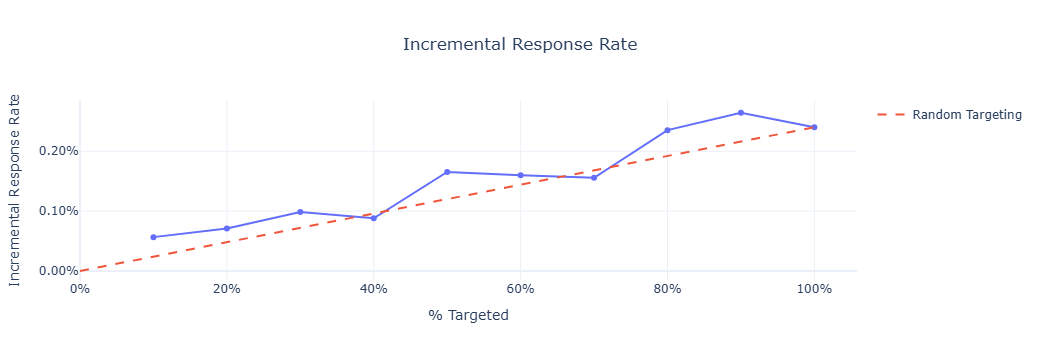

In [19]:
fig = plot_incremental_response_rate(qini_bins)
fig.show()